In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pickle

In [ ]:
#INPUTS:
wgbs_file = ''
gene_name = wgbs_file.split('_')[2]



In [28]:
file = '/Users/khandekara2/Documents/methylationProject/01_data/all_normal_TP53_cds.bed'
df = pd.read_csv(file, sep='\t')
locations = []
for chrom, start, stop in zip(list(df['chromosome']), list(df['start']), list(df['stop'])):
    locations.append((str(chrom), int(start), int(stop)))
df['location'] = locations
grouped = df.groupby('location')
groupby = grouped.agg({'methylation_ratio': [np.mean, np.std]})
groupby.reset_index(inplace=True)
groupby.columns = groupby.columns.droplevel(0)

In [29]:
y = groupby['mean'] #mean ratio from cancer
y_err = groupby['std'] #standard deviation from cancer samples
x = np.array([i for i in range(1, groupby.shape[0] + 1)]) # ticks for each CpG in coding region
labels = list(set([i[1] for i in df.location])) #coordinate of cytosine as labels
labels.sort()
tss = 7572926 #translation start site of TP53
x_labels = [i - 7572926 for i in labels]

In [30]:
#add mutated sites to profile
mutation_dict = pickle.load(open('/Users/khandekara2/Documents/methylationProject/01_data/all_mutation_dict.pickle', 'rb'))
mutations = [] #coordinate of mutated site
mut_ratios = [] #methylation ratio of mutated site if available
frequencies = [] #frequency of mutation(# of samples it occurred in)
for loc, sample, ratio in zip(df.location, df.id, df.methylation_ratio):
    if loc in mutation_dict and loc[1] not in mutations:
        if sample in mutation_dict[loc]:
            mut_ratios.append(ratio)
        else:
            mut_ratios.append(1.1)
            
        mutations.append(loc[1])
        frequencies.append(len(mutation_dict[loc]))
        
    loc2 = (loc[0], loc[1] + 1, loc[2] + 1) #take care of the second cytosine in the dyad
    if loc2 in mutation_dict and loc[1] not in mutations:
        if sample in mutation_dict[loc2]:
            mut_ratios.append(ratio)
        else:
            mut_ratios.append(1.1)
    
        mutations.append(loc[1])
        frequencies.append(len(mutation_dict[loc2]))
               
# mut_ratios = [0.0 for _ in mutations]
print (np.array(list(mutations)))
print (mut_ratios)

[7574001 7574016 7577020 7577068 7577092 7577119 7577137 7577537 7577547
 7578210 7578261 7578373 7578387 7578405 7578456 7578462 7578473 7579881]
[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]


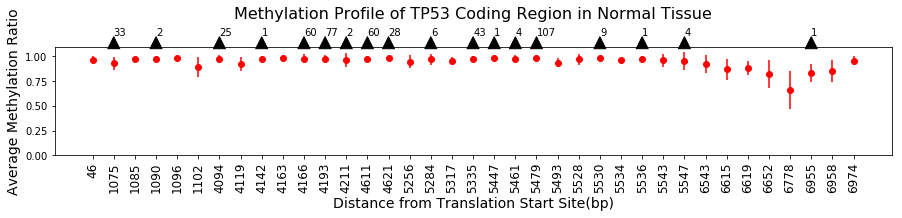

In [36]:
%matplotlib inline
fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(111)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation='vertical', fontsize=12)
ax.set_ylim((0.0, 1.1))
ax.errorbar(x, y, yerr=y_err, fmt='o', color='red')
ax.set_xlabel('Distance from Translation Start Site(bp)', fontsize=14)
ax.set_ylabel('Average Methylation Ratio', fontsize=14)
# ax.scatter(x, y2, color='red')
# ax.scatter(np.array(list(mutations)), np.array(mut_ratios), color='green')
trans = ax.get_xaxis_transform()
for u, v, f in zip(mutations, mut_ratios, frequencies):
    ax.annotate(str(f), xy=(labels.index(u) + 1, v), xycoords=trans, arrowprops=dict(facecolor='black', shrink=0.5,))
ttl = ax.title
ttl.set_position([.5, 1.2])
ax.set_title('Methylation Profile of %s Coding Region in Normal Tissue' % (gene_name), fontsize=16)
# plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('/Users/khandekara2/Documents/methylationProject/03_results/pan_cancer_%s_methylation_profile.png' % (gene_name), bbox_inches='tight')